## 1.Load the beans dataset.

In [1]:
#import tensorflow as tf
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
# Enable eager execution
tf.enable_v2_behavior()

## load the dataset

Please install tensorflow_datasets packages using

pip install tensorflow_datasets

In [2]:

%%time
import importlib

def import_or_install(library):
    try:
        importlib.import_module(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} has been successfully installed.")

# Example usage:
libraries_to_check = ["tensorflow_datasets"]

for library in libraries_to_check:
    import_or_install(library)

tensorflow_datasets is already installed.
CPU times: total: 1.2 s
Wall time: 1.6 s


In [3]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True)

print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\aldul\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        '

In [4]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)
  

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [5]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
print(bn_info.features.shape)
print(bn_info.features.np_dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].np_dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': <class 'numpy.uint8'>, 'label': <class 'numpy.int64'>}
(500, 500, 3)
<class 'numpy.uint8'>


In [7]:
import tensorflow as tf
from tensorflow.data import Dataset

# Assuming you have a pre-loaded image dataset `image_dataset`

# Convert dataset to a NumPy array (images and labels)
data_array = tfds.as_numpy(bn_train)

for imgs, labels in data_array:
    print (imgs.shape, labels.shape)
    break

(500, 500, 3) ()


In [8]:

# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)


Perform the similar tasks for the validation dataset

In [9]:
 bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


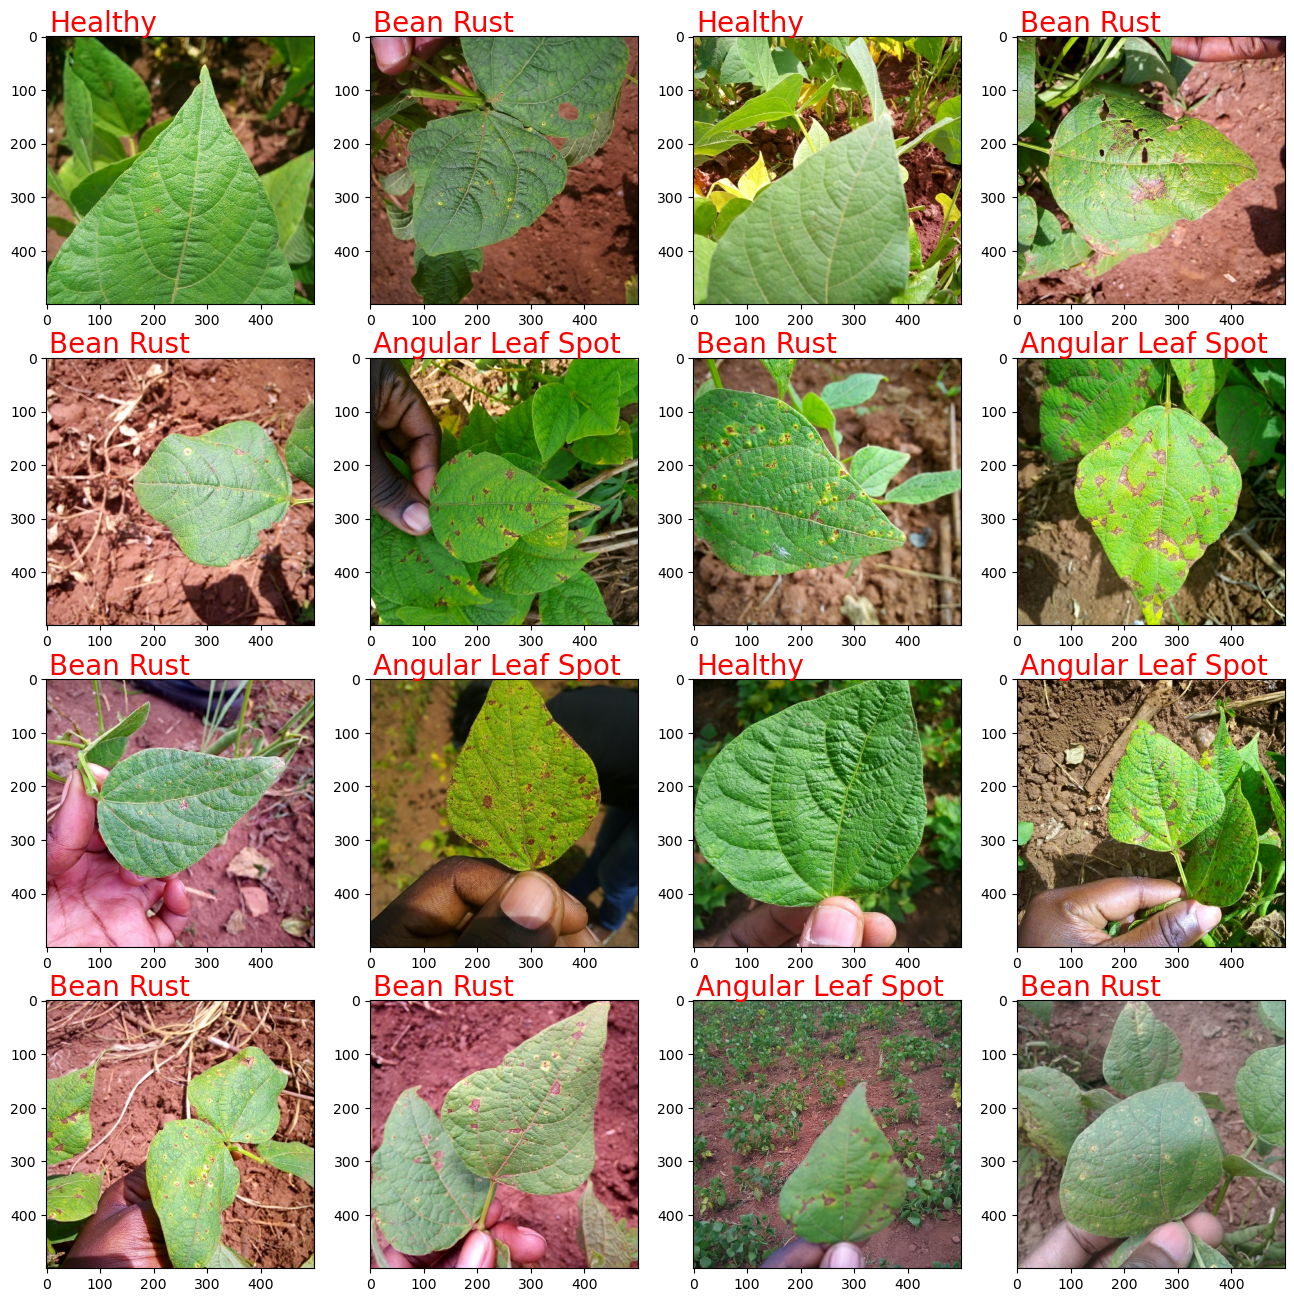

In [11]:
# take out one batch that is 32 images
example = bn_train.take(1)
# each batch has two componets, image and label
# sample=(image, lable)
for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    # we label the subplots using names instead of magic numbers such as 0, 1 and 2
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

## Convert TensorFlow Dataset to Numpy Array to Inspect the Pixel Values

In [12]:
import tensorflow as tf
from tensorflow.data import Dataset


# Convert dataset to a NumPy array (images and labels)
image_array = tfds.as_numpy(bn_train)

for img in image_array:
    print (imgs.shape)
    break

(500, 500, 3)


In [13]:
img[0]

array([[[[0.43137255, 0.30980393, 0.19607843],
         [0.4392157 , 0.31764707, 0.20392157],
         [0.4       , 0.2784314 , 0.16470589],
         ...,
         [0.27058825, 0.17254902, 0.05098039],
         [0.28627452, 0.1882353 , 0.06666667],
         [0.2784314 , 0.18039216, 0.05882353]],

        [[0.43529412, 0.3137255 , 0.2       ],
         [0.41960785, 0.29803923, 0.18431373],
         [0.4117647 , 0.2901961 , 0.1764706 ],
         ...,
         [0.33333334, 0.23137255, 0.10196079],
         [0.29411766, 0.19215687, 0.0627451 ],
         [0.28235295, 0.18039216, 0.05098039]],

        [[0.47058824, 0.34901962, 0.23529412],
         [0.4117647 , 0.2901961 , 0.1764706 ],
         [0.47058824, 0.34901962, 0.23529412],
         ...,
         [0.4117647 , 0.3019608 , 0.14901961],
         [0.33333334, 0.22352941, 0.07058824],
         [0.29411766, 0.18431373, 0.03137255]],

        ...,

        [[0.07058824, 0.11372549, 0.        ],
         [0.06666667, 0.10980392, 0.        ]

In [14]:

print(f'The maximum value of pixels = {np.amax(img[0])}; the minimum value of pixels ={np.amin(img[0])}' )

The maximum value of pixels = 1.0; the minimum value of pixels =0.0


In [15]:
input_shape =imgs.shape
input_shape

(500, 500, 3)

In [16]:
model = models.Sequential()
# Get the image size using codes instead of using magic number (32,32,3)
input_shape =imgs.shape
print(f'The input shape = {input_shape}')
# The first Convolution layer has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# The Third Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 2*2
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

The input shape = (500, 500, 3)


D:\aldul\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Q2/Split the data into a training and a test dataset.

In [17]:

import tensorflow as tf
import tensorflow_datasets as tfds


(bn_train, bn_validation, bn_test), bn_info = tfds.load(
    name='beans',
    split=['train', 'validation', 'test'],
    as_supervised=True,
    with_info=True
)


batch_size = 32


training_dataset = bn_train.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
training_dataset = training_dataset.cache().shuffle(1000)
training_dataset = training_dataset.shuffle(bn_info.splits['train'].num_examples)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.prefetch(tf.data.experimental.AUTOTUNE)


test_dataset = bn_test.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


## Q3/Build a CNN network to perform image classification using TensorFlow.

In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


train_images, test_images = train_images / 255.0, test_images / 255.0


def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes)
    ])
    return model


input_shape = train_images[0].shape
num_classes = 10
cnn_model = create_cnn_model(input_shape, num_classes)


cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = cnn_model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3589 - loss: 1.7316 - val_accuracy: 0.5666 - val_loss: 1.2010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5869 - loss: 1.1557 - val_accuracy: 0.6420 - val_loss: 1.0169
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6483 - loss: 0.9981 - val_accuracy: 0.6567 - val_loss: 0.9859
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6853 - loss: 0.8944 - val_accuracy: 0.6807 - val_loss: 0.9122
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7193 - loss: 0.8049 - val_accuracy: 0.6844 - val_loss: 0.9137
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7378 - loss: 0.7592 - val_accuracy: 0.6965 - val_loss: 0.8862
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7567 - loss: 0.7030 - val_accuracy: 0.7144 - val_loss: 0.8384
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7759 -

## Does it overfit or underfit the data? Please justify your answer.
it seems like your model is slightly overfitting the data


## Q4/use data augmentation techniques to build a CNN network using TensorFlow with same network architecture

In [19]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


train_images, test_images = train_images / 255.0, test_images / 255.0


datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)


def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes)
    ])
    return model


input_shape = train_images[0].shape
num_classes = 10
cnn_model = create_cnn_model(input_shape, num_classes)


cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


batch_size = 32
steps_per_epoch = len(train_images) // batch_size
history = cnn_model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                        steps_per_epoch=steps_per_epoch, epochs=10,
                        validation_data=(test_images, test_labels))

test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")


Epoch 1/10
   3/1562 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - accuracy: 0.1042 - loss: 2.3089  

D:\aldul\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.3345 - loss: 1.8014 - val_accuracy: 0.5460 - val_loss: 1.2657
Epoch 2/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.4062 - loss: 1.5329

D:\aldul\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 990us/step - accuracy: 0.4062 - loss: 0.7669 - val_accuracy: 0.5474 - val_loss: 1.2682
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.5136 - loss: 1.3463 - val_accuracy: 0.5868 - val_loss: 1.1762
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.6562 - loss: 0.5554 - val_accuracy: 0.5876 - val_loss: 1.1813
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.5641 - loss: 1.2214 - val_accuracy: 0.6323 - val_loss: 1.0322
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6562 - loss: 0.4538 - val_accuracy: 0.6398 - val_loss: 1.0227
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.6054 - loss: 1.1120 - val_accuracy: 0.6567 - val_loss: 0.9609
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6562 - loss: 0.5156 - val_accuracy: 0.6582 - val_loss: 0.9590
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6285 - loss: 1.0465 -

## Does it produce better performance on the test dataset?
The accuracy of the test data dropped from about 71% to around 65%. This means the model wasn't as good at making predictions but not doing as well when tested.

## Q5/ Build a CNN network using transfer learning and TensorFlow by choosing a pre-trained model.

In [20]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


train_images, test_images = train_images / 255.0, test_images / 255.0


train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


base_model = MobileNetV2(input_shape=(32, 32, 3), weights='imagenet', include_top=False)


base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)


history = model.fit(train_generator,
                    steps_per_epoch=len(train_images) // batch_size,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_images) // batch_size)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")


C:\Users\aldul\AppData\Local\Temp\ipykernel_10880\4138180641.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), weights='imagenet', include_top=False)


Epoch 1/10


D:\aldul\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 46ms/step - accuracy: 0.1003 - loss: 2.3063 - val_accuracy: 0.1259 - val_loss: 2.2996
Epoch 2/10


D:\aldul\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 1.1544
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.1130 - loss: 2.2991 - val_accuracy: 0.1483 - val_loss: 2.2885
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.1519
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.1300 - loss: 2.2887 - val_accuracy: 0.1398 - val_loss: 2.2697
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 135us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 1.1342
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.1376 - loss: 2.2734 - val_accuracy: 0.1350 - val_loss: 2.2671
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 1.1176
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step 

##  Does it produce better performance on the test datasets?
The model didn't learn much from the training data, and it also didn't do well on new data. It needs improvement to perform better.